In [1]:
# -*- coding: <encoding-name> -*-

### 데이터를 생성할 때 근소한 차이가 있을 수 있으니, 보고서와 같은 결과를 얻기 위해서는 별도로 첨부한
###  osan_dataset.geojson / syn_dataset.geojson을 사용하셔야 합니다.
#### 'osan.geojson' 대신 'osan_dataset.geojson'(별도 첨부)
#### 'syn.geojson' 대신 'syn_dataset.geojson'(별도 첨부)

# 최종 모델링

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import json
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import seaborn as sns
from collections import Counter

In [3]:
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, VotingRegressor

from lightgbm import LGBMRegressor

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

import graphviz
import warnings

In [4]:
# 최종 머신러닝 분석을 위한 데이터 로드

osan = gpd.read_file('osan_dataset.geojson')
syn = gpd.read_file('syn_dataset.geojson')

### 필요 함수 정의

In [7]:
# 각각 root-mean-squared-error / mean abosolute error 구해주는 함수

def RMSE(y, pred):
    rmse = ( np.sum([x**2 for x in (np.array(y)-np.array(pred))]) / len(y) )**(1/2)
    return round(rmse, 4)
    
def MAE(y, pred):
    mae = np.sum([np.abs(x) for x in (np.array(y)-np.array(pred))]) / len(y)
    return round(mae, 4)

In [8]:
# data를 train / test로 split 해주는 함수

def data_split(dataframe, col_list, row_idx, train_size, seed):
        
    data = dataframe.loc[row_idx, col_list]
    train, test = train_test_split(data, test_size=train_size, random_state=seed)

    x_train = train.iloc[:, list(range(2, len(train.columns)))]
    y_train = train.iloc[:, 1]
    x_test = test.iloc[:, list(range(2, len(test.columns)))]
    y_test = test.iloc[:, 1]
    
    return [x_train, y_train, x_test, y_test]

## 다양한 모델 비교

In [5]:
# 다양한 머신러닝 기법 중 합성데이터를 가장 잘 학습하는 모형 탐색
# train / test 데이터로 합성데이터를 분할
# 각 모형의 test R2 score, Rmse를 통해 추후 분석에 활용할 기법 선택

In [6]:
import mglearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor

In [9]:
# 합성데이터를 모형 학습에 적용할 수 있도록 train / test 데이터로 나눔

row_idx = list(range(len(osan)))
clist = ['gid','사고횟수_가중치','단속카메라','도로안내표지','횡단보도_전체면적','신호등','단속횟수','단속횟수_횡단보도위','traffic_sum',
         'freq_sum','초등학교_300m','유치원_500m','cctv','버스정류장','체육시설','학원','car_cnt','float_type_H','float_type_M']

x_train, y_train, x_test, y_test = data_split(dataframe=syn, col_list=clist, row_idx=row_idx, train_size=0.3, seed=123)

In [10]:
# 라쏘 회귀

lasso = Lasso()
lasso.fit(x_train, y_train)

print("train set R^2 : {:.3f}".format(lasso.score(x_train, y_train)))
print("valid set R^2 : {:.3f}".format(lasso.score(x_test, y_test)))
print("valid set Rms : {:.3f}".format(RMSE(y=y_test, pred=lasso.predict(x_test))))

train set R^2 : 0.544
valid set R^2 : 0.573
valid set Rms : 0.928


In [11]:
# GradientBoosting 회귀

gbrt = GradientBoostingRegressor(random_state=123)
gbrt.fit(x_train, y_train)

print("train set R^2 : {:.3f}".format(gbrt.score(x_train, y_train)))
print("test set R^2 : {:.3f}".format(gbrt.score(x_test, y_test)))
print("valid set Rms : {:.3f}".format(RMSE(y=y_test, pred=gbrt.predict(x_test))))

train set R^2 : 0.804
test set R^2 : 0.718
valid set Rms : 0.754


In [12]:
# 릿지 회귀

rid = Ridge()
rid.fit(x_train, y_train)

print("train set R^2 : {:.3f}".format(rid.score(x_train, y_train)))
print("valid set R^2 : {:.3f}".format(rid.score(x_test, y_test)))
print("valid set Rms : {:.3f}".format(RMSE(y=y_test, pred=rid.predict(x_test))))

train set R^2 : 0.613
valid set R^2 : 0.638
valid set Rms : 0.855


In [13]:
# KNN 회귀

kn = KNeighborsRegressor()
kn.fit(x_train, y_train)

print("train set R^2 : {:.3f}".format(kn.score(x_train, y_train)))
print("test set R^2 : {:.3f}".format(kn.score(x_test, y_test)))
print("valid set Rms : {:.3f}".format(RMSE(y=y_test, pred=kn.predict(x_test))))

train set R^2 : 0.646
test set R^2 : 0.410
valid set Rms : 1.092


In [14]:
# RandomForest 회귀

rf = RandomForestRegressor(random_state=123)
rf.fit(x_train, y_train)

print("train set R^2 : {:.3f}".format(rf.score(x_train, y_train)))
print("test set R^2 : {:.3f}".format(rf.score(x_test, y_test)))
print("valid set Rms : {:.3f}".format(RMSE(y=y_test, pred=rf.predict(x_test))))

train set R^2 : 0.952
test set R^2 : 0.740
valid set Rms : 0.725


In [15]:
# 의사결정나무 기반 Adaboost 회귀

adatree = AdaBoostRegressor(DecisionTreeRegressor(),random_state=123)
adatree.fit(x_train, y_train)

print("train set R^2 : {:.3f}".format(adatree.score(x_train, y_train)))
print("valid set R^2 : {:.3f}".format(adatree.score(x_test, y_test)))
print("valid set Rms : {:.3f}".format(RMSE(y=y_test, pred=adatree.predict(x_test))))

train set R^2 : 0.984
valid set R^2 : 0.722
valid set Rms : 0.749


In [16]:
# 의사결정나무 기반 Bagging 회귀

bag = BaggingRegressor(random_state=123)
bag.fit(x_train, y_train)

print("train set R^2 : {:.3f}".format(bag.score(x_train, y_train)))
print("valid set R^2 : {:.3f}".format(bag.score(x_test, y_test)))
print("valid set Rms : {:.3f}".format(RMSE(y=y_test, pred=bag.predict(x_test))))

train set R^2 : 0.938
valid set R^2 : 0.724
valid set Rms : 0.747


In [17]:
# ElasticNet 회귀

ela = ElasticNet()
ela.fit(x_train, y_train)

print("train set R^2 : {:.3f}".format(ela.score(x_train, y_train)))
print("valid set R^2 : {:.3f}".format(ela.score(x_test, y_test)))
print("valid set Rms : {:.3f}".format(RMSE(y=y_test, pred=ela.predict(x_test))))

train set R^2 : 0.553
valid set R^2 : 0.588
valid set Rms : 0.912


In [18]:
# LightGradientBoosting 회귀

lgbm = LGBMRegressor(random_state=123)
lgbm.fit(x_train, y_train)

print("train set R^2 : {:.3f}".format(lgbm.score(x_train, y_train)))
print("test set R^2 : {:.3f}".format(lgbm.score(x_test, y_test)))
print("valid set Rms : {:.3f}".format(RMSE(y=y_test, pred=lgbm.predict(x_test))))

train set R^2 : 0.915
test set R^2 : 0.740
valid set Rms : 0.725


In [19]:
# eXtremeGradientBoosting 회귀

xgb = XGBRegressor()
xgb.fit(x_train, y_train)

print("train set R^2 : {:.3f}".format(xgb.score(x_train, y_train)))
print("test set R^2 : {:.3f}".format(xgb.score(x_test, y_test)))
print("valid set Rms : {:.3f}".format(RMSE(y=y_test, pred=xgb.predict(x_test))))

train set R^2 : 0.973
test set R^2 : 0.741
valid set Rms : 0.723


## 선택된 모델 성능 비교 : RandomForest, LightGBM, XGB

In [20]:
# 모델 학습 및 성능 비교 개요
# 1. 합성데이터의 train set으로 모형 학습
# 2. 합성데이터의 test set으로 모형의 성능 1차 평가
# 3. 합성데이터로 학습시킨 모형으로 원본데이터 예측 후 모형의 성능 2차 평가

## 개별 모델 함수 정의

In [21]:
#     RF_reg(dataframe, col_list, row_idx, train_size, seed)
#   LGBM_reg(dataframe, col_list, row_idx, train_size, seed)
#    XGB_reg(dataframe, col_list, row_idx, train_size, seed)
# Voting_reg(model_list, dataframe, col_list, row_idx, train_size, seed)

# 정의되는 함수에서 dataframe은 {INDEX + Y + X Variables}의 형태로 
#                   col_list는 dataframe의 X Variables 중에서 분석에 사용할 feature만 모은 리스트
#                   row_idx는  dataframe의 모든 행 중에서 분석에 사용할 행만 모은 리스트
#                   train_size는 dataframe을 train / test set으로 나눌 때 test set의 크기(0~1)
#                   seed는 랜덤 시드 명시

In [22]:
def RF_reg(dataframe, col_list, row_idx, train_size, seed):
    
    warnings.filterwarnings(action='ignore')
    
# data를 train / test로 split
    data = dataframe.loc[row_idx, col_list]
    train, test = train_test_split(data, test_size=train_size, random_state=seed)
    
# train / test를 x(feature 모음) / y 로 변환
    x_train = train.iloc[:, list(range(2, len(train.columns)))]
    y_train = train.iloc[:, 1]
    x_test = test.iloc[:, list(range(2, len(test.columns)))]
    y_test = test.iloc[:, 1]

# 하이퍼파라미터 튜닝
    params = {'n_estimators': [100, 200, 300, 400, 500],
              'max_depth': [2,4,6,8,10],
              'min_samples_split': [1,3,5,7,9],
              'min_samples_leaf': [1,3,5,7,9]}

    model = RandomForestRegressor(random_state=seed)
    
    search = RandomizedSearchCV(estimator=model, param_distributions=params, scoring='neg_root_mean_squared_error',
                                n_iter=30, cv = 5, n_jobs = -1, random_state=seed)
    search.fit(x_train, y_train)
    
# 최적의 하이퍼파라미터로 모델 적합
    model = RandomForestRegressor(n_estimators=search.best_params_['n_estimators'],
                                  max_depth=search.best_params_['max_depth'],
                                  min_samples_split=search.best_params_['min_samples_split'],
                                  min_samples_leaf=search.best_params_['min_samples_leaf'],
                                  random_state=seed)
    model.fit(x_train ,y_train)

# 학습한 모델과 사용된 데이터셋 반환
    return [model, x_train, y_train, x_test, y_test]

    warnings.filterwarnings(action='default')

In [23]:
def LGBM_reg(dataframe, col_list, row_idx, train_size, seed):
    
    warnings.filterwarnings(action='ignore')
    
# data를 train / test로 split
    data = dataframe.loc[row_idx, col_list]
    train, test = train_test_split(data, test_size=train_size, random_state=seed)

# train / test를 x(feature 모음) / y 로 변환
    x_train = train.iloc[:, list(range(2, len(train.columns)))]
    y_train = train.iloc[:, 1]
    x_test = test.iloc[:, list(range(2, len(test.columns)))]
    y_test = test.iloc[:, 1]
    
# 하이퍼파라미터 튜닝
    params = {'n_estimators': [100, 300, 500],
              'learning_rate': [0.01,0.05,0.1],
              'max_depth': [2,6,10],
              'num_leaves': [8,24,40],
              'num_iterations':[500]}

    model = LGBMRegressor(random_state=seed)
    
    search = RandomizedSearchCV(estimator=model, param_distributions=params, scoring='neg_root_mean_squared_error',
                                   n_iter=30, cv = 5, n_jobs = -1, random_state=seed)
    search.fit(x_train, y_train)
    
# 최적의 하이퍼파라미터로 모델 적합
    model = LGBMRegressor(n_estimators=search.best_params_['n_estimators'],
                          learning_rate=search.best_params_['learning_rate'],
                          max_depth=search.best_params_['max_depth'],
                          num_leaves=search.best_params_['num_leaves'],
                          num_iterations=search.best_params_['num_iterations'],
                          random_state=seed)
    model.fit(x_train ,y_train)
    
# 학습한 모델과 사용된 데이터셋 반환
    return [model, x_train, y_train, x_test, y_test]

    warnings.filterwarnings(action='default')

In [24]:
from xgboost import XGBRegressor

def XGB_reg(dataframe, col_list, row_idx, train_size, seed):
    
    warnings.filterwarnings(action='ignore')
    
# data를 train / test로 split
    data = dataframe.loc[row_idx, col_list]
    train, test = train_test_split(data, test_size=train_size, random_state=seed)

# train / test를 x(feature 모음) / y 로 변환
    x_train = train.iloc[:, list(range(2, len(train.columns)))]
    y_train = train.iloc[:, 1]
    x_test = test.iloc[:, list(range(2, len(test.columns)))]
    y_test = test.iloc[:, 1]
    
# 하이퍼파라미터 튜닝
    params = {'n_estimators': [100, 300, 500],
              'learning_rate': [0.01,0.05,0.1],
              'max_depth': [2,6,10],
             }

    model = XGBRegressor()
    
    search = RandomizedSearchCV(estimator=model, param_distributions=params, scoring='neg_root_mean_squared_error',
                                n_iter=30, cv = 5, n_jobs = -1, random_state=seed)
    search.fit(x_train, y_train)
    
# 최적의 하이퍼파라미터로 모델 적합
    model = XGBRegressor(n_estimators=search.best_params_['n_estimators'],
                         learning_rate=search.best_params_['learning_rate'],
                         max_depth=search.best_params_['max_depth'],
                         #nrounds=search.best_params_['nrounds'],
                         random_state=seed)
    model.fit(x_train, y_train)

# 학습한 모델과 사용된 데이터셋 반환
    return [model, x_train, y_train, x_test, y_test]

    warnings.filterwarnings(action='default')

In [25]:
from sklearn.ensemble import VotingRegressor

def Voting_reg(model_list, dataframe, col_list, row_idx, train_size, seed):
    
    warnings.filterwarnings(action='ignore')

# 보팅 모델에 사용할 모델 3개 저장
    model1 = model_list[0]
    model2 = model_list[1]
    model3 = model_list[2]
    models = [('m1', model1), ('m2', model2), ('m3', model3)]

    
# data를 train / test로 split
    data = dataframe.loc[row_idx, col_list]
    train, test = train_test_split(data, test_size=train_size, random_state=seed)

# train / test를 x(feature 모음) / y 로 변환
    x_train = train.iloc[:, list(range(2, len(train.columns)))]
    y_train = train.iloc[:, 1]
    x_test = test.iloc[:, list(range(2, len(test.columns)))]
    y_test = test.iloc[:, 1]

# 보팅 모델 적합(각각의 개별 모델은 하이퍼파라미터 튜닝 완료)
    model = VotingRegressor(estimators=models)
    model.fit(x_train, y_train)
    
    return [model, x_train, y_train, x_test, y_test]

    warnings.filterwarnings(action='default')

In [26]:
from sklearn.model_selection import KFold

def get_stacking_data(dataframe, col_list, row_idx, train_size, seed, model, nfold):
    
    warnings.filterwarnings(action='ignore')
        
# data를 train / test로 split
    data = dataframe.loc[row_idx, col_list]
    train, test = train_test_split(data, test_size=train_size, random_state=seed)
    
    train = train.reset_index(drop=True, inplace=False)
    test = test.reset_index(drop=True, inplace=False)

    x_train = train.iloc[:, list(range(2, len(train.columns)))]
    y_train = train.iloc[:, 1]
    x_test = test.iloc[:, list(range(2, len(test.columns)))]
    y_test = test.iloc[:, 1]
    
# 스태킹 모형의 x_matrix / y 분할을 위해 k-fold 시행 
    kfold = KFold(n_splits=nfold, random_state=seed)

# cross-validation을 활용해 스태킹 모형에서 학습과 성능 비교할 데이터프레임 생성
    train_fold_predict = np.zeros((x_train.shape[0], 1))
    test_predict = np.zeros((x_test.shape[0], nfold))

# k-fold의 k번 반복
# k-fold의 train_으로 학습한 모델로 validation을 예측한 값을 train_fold_predict에 쌓음
    for cnt, (train_index, valid_index) in enumerate(kfold.split(x_train)):
        x_train_ = x_train.iloc[train_index]
        y_train_ = y_train.iloc[train_index]
        x_validation = x_train.iloc[valid_index]
        
        model.fit(x_train_, y_train_)
        
        train_fold_predict[valid_index, :] = model.predict(x_validation).reshape(-1, 1)
        test_predict[:, cnt] = model.predict(x_test)

# test_predict_mean은 모형의 성능 비교할 때 사용
    test_predict_mean = np.mean(test_predict, axis=1).reshape(-1, 1)
    
    return [train_fold_predict, test_predict_mean, x_train, y_train, x_test, y_test]
    
    warnings.filterwarnings(action='default')

### RandomForest

In [29]:
# 합성데이터로 RF reg fitting

row_idx = list(range(len(osan)))
clist = ['gid','사고횟수_가중치','단속카메라','도로안내표지','횡단보도_전체면적','신호등','단속횟수','단속횟수_횡단보도위','traffic_sum',
         'freq_sum','초등학교_300m','유치원_500m','cctv','버스정류장','체육시설','학원','car_cnt','float_type_H','float_type_M']

result_RF = RF_reg(dataframe=syn, col_list=clist, row_idx=row_idx, train_size=0.3, seed=123)

model_RF = result_RF[0]
x_test_RF = result_RF[3]
y_test_RF = result_RF[4]

In [30]:
# 합성데이터 test set rmse / mae

test_rmse_RF = RMSE(y = y_test_RF, pred = model_RF.predict(x_test_RF))
test_mae_RF = MAE(y = y_test_RF, pred = model_RF.predict(x_test_RF))

test_rmse_RF, test_mae_RF

(0.7187, 0.4338)

In [31]:
# 원본데이터 예측 rmse / mae

row_idx = list(range(len(osan)))
clist = ['gid','사고횟수_가중치','단속카메라','도로안내표지','횡단보도_전체면적','신호등','단속횟수','단속횟수_횡단보도위','traffic_sum',
         'freq_sum','초등학교_300m','유치원_500m','cctv','버스정류장','체육시설','학원','car_cnt','float_type_H','float_type_M']
clist = clist[2:len(clist)]
design = osan.loc[:, clist]

y = osan.사고횟수_가중치
pred = model_RF.predict(design)

valid_rmse_RF = RMSE(y = y, pred = pred)
valid_mae_RF = MAE (y = y, pred = pred)

valid_rmse_RF, valid_mae_RF

(0.9178, 0.5095)

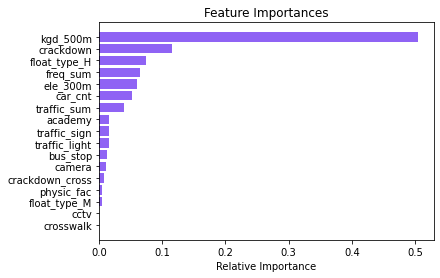

In [32]:
# 랜덤포레스트 변수중요도 플랏

clist = ['gid','사고횟수_가중치','camera','traffic_sign','crosswalk','traffic_light','crackdown','crackdown_cross','traffic_sum',
         'freq_sum','ele_300m','kgd_500m','cctv','bus_stop','physic_fac','academy','car_cnt','float_type_H','float_type_M']
clist = clist[2:len(clist)]

importances = model_RF.feature_importances_
indices = np.argsort(importances)

feature_name = []
for i in indices:
    feature_name.append(clist[i])

plt.title('Feature Importances')
plt.barh(feature_name, importances[indices], color='#8f63f4', align='center')
plt.xlabel('Relative Importance')
plt.show()

### Light Gradient Boosting

In [33]:
# 합성데이터로 LGBM reg fitting

row_idx = list(range(len(osan)))
clist = ['gid','사고횟수_가중치','단속카메라','도로안내표지','횡단보도_전체면적','신호등','단속횟수','단속횟수_횡단보도위','traffic_sum',
         'freq_sum','초등학교_300m','유치원_500m','cctv','버스정류장','체육시설','학원','car_cnt','float_type_H','float_type_M']

result_LGBM = LGBM_reg(dataframe=syn, col_list=clist, row_idx=row_idx, train_size=0.3, seed=123)

model_LGBM = result_LGBM[0]
x_test_LGBM = result_LGBM[3]
y_test_LGBM = result_LGBM[4]

In [34]:
# 합성데이터 test set rmse / mae

test_rmse_LGBM = RMSE(y = y_test_LGBM, pred = model_LGBM.predict(x_test_LGBM))
test_mae_LGBM = MAE(y = y_test_LGBM, pred = model_LGBM.predict(x_test_LGBM))

test_rmse_LGBM, test_mae_LGBM

(0.7357, 0.4433)

In [35]:
# 원본데이터 예측 rmse / mae

row_idx = list(range(len(osan)))
clist = ['gid','사고횟수_가중치','단속카메라','도로안내표지','횡단보도_전체면적','신호등','단속횟수','단속횟수_횡단보도위','traffic_sum',
         'freq_sum','초등학교_300m','유치원_500m','cctv','버스정류장','체육시설','학원','car_cnt','float_type_H','float_type_M']
clist = clist[2:len(clist)]
design = osan.loc[:, clist]

y = osan.사고횟수_가중치
pred = model_LGBM.predict(design)

valid_rmse_LGBM = RMSE(y = y, pred = pred)
valid_mae_LGBM = MAE (y = y, pred = pred)

valid_rmse_LGBM, valid_mae_LGBM

(0.9116, 0.5118)

### XGB

In [36]:
# 합성데이터로 XGB reg fitting

row_idx = list(range(len(osan)))
clist = ['gid','사고횟수_가중치','단속카메라','도로안내표지','횡단보도_전체면적','신호등','단속횟수','단속횟수_횡단보도위','traffic_sum',
         'freq_sum','초등학교_300m','유치원_500m','cctv','버스정류장','체육시설','학원','car_cnt','float_type_H','float_type_M']

result_XGB = XGB_reg(dataframe=syn, col_list=clist, row_idx=row_idx, train_size=0.3, seed=123)

model_XGB = result_XGB[0]
x_test_XGB = result_XGB[3]
y_test_XGB = result_XGB[4]

In [37]:
# 합성데이터 test set rmse / mae

test_rmse_XGB = RMSE(y = y_test_XGB, pred = model_XGB.predict(x_test_XGB))
test_mae_XGB = MAE(y = y_test_XGB, pred = model_XGB.predict(x_test_XGB))

test_rmse_XGB, test_mae_XGB

(0.7145, 0.4326)

In [38]:
# 원본데이터 예측 rmse / mae

row_idx = list(range(len(osan)))
clist = ['gid','사고횟수_가중치','단속카메라','도로안내표지','횡단보도_전체면적','신호등','단속횟수','단속횟수_횡단보도위','traffic_sum',
         'freq_sum','초등학교_300m','유치원_500m','cctv','버스정류장','체육시설','학원','car_cnt','float_type_H','float_type_M']
clist = clist[2:len(clist)]
design = osan.loc[:, clist]

y = osan.사고횟수_가중치
pred = model_XGB.predict(design)

valid_rmse_XGB = RMSE(y = y, pred = pred)
valid_mae_XGB = MAE (y = y, pred = pred)

valid_rmse_XGB, valid_mae_XGB

(0.9205, 0.5091)

### Voting regressor

In [39]:
# 합성데이터로 Voting reg fitting
# Voting regressor에 참여할 모형: RF, LGBM, XGB
mlist = [model_RF, model_LGBM, model_XGB]

row_idx = list(range(len(osan)))
clist = ['gid','사고횟수_가중치','단속카메라','도로안내표지','횡단보도_전체면적','신호등','단속횟수','단속횟수_횡단보도위','traffic_sum',
         'freq_sum','초등학교_300m','유치원_500m','cctv','버스정류장','체육시설','학원','car_cnt','float_type_H','float_type_M']

result_ESB = Voting_reg(model_list=mlist, dataframe=syn, col_list=clist, row_idx=row_idx, train_size=0.3, seed=123)

model_ESB = result_ESB[0]
x_test_ESB = result_ESB[3]
y_test_ESB = result_ESB[4]

In [40]:
# 합성데이터 test set rmse / mae

test_rmse_ESB = RMSE(y = y_test_ESB, pred = model_ESB.predict(x_test_ESB))
test_mae_ESB = MAE(y = y_test_ESB, pred = model_ESB.predict(x_test_ESB))

test_rmse_ESB, test_mae_ESB

(0.7099, 0.4304)

In [41]:
# 원본데이터 예측 rmse / mae

row_idx = list(range(len(osan)))
clist = ['gid','사고횟수_가중치','단속카메라','도로안내표지','횡단보도_전체면적','신호등','단속횟수','단속횟수_횡단보도위','traffic_sum',
         'freq_sum','초등학교_300m','유치원_500m','cctv','버스정류장','체육시설','학원','car_cnt','float_type_H','float_type_M']
clist = clist[2:len(clist)]
design = osan.loc[:, clist]

y = osan.사고횟수_가중치
pred = model_ESB.predict(design)

valid_rmse_ESB = RMSE(y = y, pred = pred)
valid_mae_ESB = MAE (y = y, pred = pred)

valid_rmse_ESB, valid_mae_ESB

(0.9035, 0.5042)

### Stacking

In [42]:
# RF, LGBM, XGB 3가지로 스태킹 모델 fitting

row_idx = list(range(len(osan)))
clist = ['gid','사고횟수_가중치','단속카메라','도로안내표지','횡단보도_전체면적','신호등','단속횟수','단속횟수_횡단보도위','traffic_sum',
         'freq_sum','초등학교_300m','유치원_500m','cctv','버스정류장','체육시설','학원','car_cnt','float_type_H','float_type_M']

# RF, LGBM, XGB의 세 모형으로 스태킹 데이터 생성
stack_RF = get_stacking_data(dataframe=syn, col_list=clist, row_idx=row_idx, train_size=0.3, seed=123, model=model_RF, nfold=5)
stack_LGBM = get_stacking_data(dataframe=syn, col_list=clist, row_idx=row_idx, train_size=0.3, seed=123, model=model_LGBM, nfold=5)
stack_XGB = get_stacking_data(dataframe=syn, col_list=clist, row_idx=row_idx, train_size=0.3, seed=123, model=model_XGB, nfold=5)

# 모형_train은 cross-validation에서 train으로 학습된 모형에서 validation set의 예측값 모음
# 모형_test는 cross_validation에서 모형 학습에 사용되지 않은 test 용 데이터의 예측값 모음
RF_train, LGBM_train, XGB_train = stack_RF[0], stack_LGBM[0], stack_XGB[0]
RF_test, LGBM_test, XGB_test = stack_RF[1], stack_LGBM[1], stack_XGB[1]

# 최종 모형 학습을 위해 3가지 모형_train을 모아서 new_x_train으로 병합
# 최종 모형 학습에 사용될 label은 y_train
new_x_train = np.concatenate((RF_train, LGBM_train, XGB_train), axis=1)
y_train = stack_RF[3]

# 모형의 성능 평가를 위한 test용 데이터의 예측값 모음 또한 new_x_test로 병합
new_x_test = np.concatenate((RF_test, LGBM_test, XGB_test), axis=1)

# 스태킹을 통해 산출된 새로운 데이터로 최종 모형 학습
model_STACK = LGBMRegressor(n_estimators=100, random_state=123)
model_STACK.fit(new_x_train, y_train)

LGBMRegressor(random_state=123)

In [43]:
# 합성데이터 test set rmse / mae

# y_test_STACK은 모형 평가를 위한 실제 test용 데이터의 label
# pred_test_STACK은 test용 데이터의 예측값
y_test_STACK = stack_RF[5]
pred_test_STACK = model_STACK.predict(new_x_test)

test_rmse_STACK = RMSE(y = y_test_STACK, pred = pred_test_STACK)
test_mae_STACK = MAE(y = y_test_STACK, pred = pred_test_STACK)

test_rmse_STACK, test_mae_STACK

(0.7681, 0.4571)

In [44]:
# 원본데이터로 예측 rmse / mae

clist = ['gid','사고횟수_가중치','단속카메라','도로안내표지','횡단보도_전체면적','신호등','단속횟수','단속횟수_횡단보도위','traffic_sum',
         'freq_sum','초등학교_300m','유치원_500m','cctv','버스정류장','체육시설','학원','car_cnt','float_type_H','float_type_M']
clist = clist[2:len(clist)]
design = osan.loc[:, clist]

# 원본데이터를 model_STACK로 예측하기 위해 3가지 모형(RF. LGBM, XGB)의 예측값 구함
RF_valid = model_RF.predict(design)
LGBM_valid = model_LGBM.predict(design)
XGB_valid = model_XGB.predict(design)

# new_x_valid는 model_STACK으로 원본데이터 예측을 위해 사용할 design matrix
new_x_valid = np.array([RF_valid, LGBM_valid, XGB_valid])
new_x_valid = np.transpose(new_x_valid)

y = osan.사고횟수_가중치
pred = model_STACK.predict(new_x_valid)

valid_rmse_STACK = RMSE(y = y, pred = pred)
valid_mae_STACK = MAE (y = y, pred = pred)

valid_rmse_STACK, valid_mae_STACK

(0.9449, 0.5245)

## 최종 모델 : Voting_Reg(RF, LGBM, XGB)

In [45]:
# 모형 비교에서 구한 최적의 하이퍼파라미터로 모형 학습

model_RF = RandomForestRegressor(max_depth=10, min_samples_split=3, n_estimators=400,
                                 random_state=123)

model_LGBM = LGBMRegressor(learning_rate=0.05, max_depth=10, num_iterations=500,
                        num_leaves=8, random_state=123)

model_XGB = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                         colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                         importance_type='gain',
                         learning_rate=0.01, max_delta_step=0, max_depth=6,
                         min_child_weight=1,
                         n_estimators=500, n_jobs=0, num_parallel_tree=1,
                         random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                         subsample=1, tree_method='exact', validate_parameters=1,
                         verbosity=None)

In [46]:
row_idx = list(range(len(osan)))
clist = ['gid','사고횟수_가중치','단속카메라','도로안내표지','횡단보도_전체면적','신호등','단속횟수','단속횟수_횡단보도위','traffic_sum',
         'freq_sum','초등학교_300m','유치원_500m','cctv','버스정류장','체육시설','학원','car_cnt','float_type_H','float_type_M']

# 개별 모형에서 사용한 train / test을 동일하게 나누기
data_pair = data_split(dataframe=syn, col_list=clist, row_idx=row_idx, train_size=0.3, seed=123)

x_train = data_pair[0]
y_train = data_pair[1]

In [47]:
# 최적화된 RandomForest, LightGBM, XGB 모형으로 Voting regressor 학습

models = [('RF', model_RF), ('LGBM', model_LGBM), ('XGB', model_XGB)]

model_ESB = VotingRegressor(estimators=models)
model_ESB.fit(x_train, y_train)

VotingRegressor(estimators=[('RF',
                             RandomForestRegressor(max_depth=10,
                                                   min_samples_split=3,
                                                   n_estimators=400,
                                                   random_state=123)),
                            ('LGBM',
                             LGBMRegressor(learning_rate=0.05, max_depth=10,
                                           num_iterations=500, num_leaves=8,
                                           random_state=123)),
                            ('XGB',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interac

## 최종 모형으로 사고 예측치 정렬

In [48]:
# 최종 모형으로 원본데이터 사고 예측

row_idx = list(range(len(osan)))
clist = ['gid','사고횟수_가중치','단속카메라','도로안내표지','횡단보도_전체면적','신호등','단속횟수','단속횟수_횡단보도위','traffic_sum',
         'freq_sum','초등학교_300m','유치원_500m','cctv','버스정류장','체육시설','학원','car_cnt','float_type_H','float_type_M']
clist = clist[2:len(clist)]
design = osan.loc[:, clist]

# 각 격자의 사고 예측값
predicted = model_ESB.predict(design)

In [49]:
# danger_place는 4510개의 격자를 사고 예측값 기준으로 정렬한 데이터

danger_place = osan.copy()

danger_place['predicted'] = predicted
danger_place = danger_place.sort_values(by=['predicted'], axis=0, ascending=False)
danger_place = danger_place.reset_index(drop=True, inplace=False)

danger_place.to_file('danger.geojson', driver='GeoJSON')

In [50]:
# 예측값 기준 상위 60개 지역 추출
# 보호구역여부는 해당 격자에 어린이 보호구역 도로가 지정되어 있는지 여부 -> 어린이 보호구역 지정 YES: 1
#                                                                        -> 어린이 보호구역 지정  NO: 0

danger = gpd.read_file('danger.geojson')

danger_top60 = danger.loc[0:59, :]
danger_top60['보호구역여부'] = [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 
                                0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 
                                0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 
                                1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 
                                0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 
                                0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

danger_top60.to_file('danger_top60.geojson', driver='GeoJSON')

In [51]:
# 예측값 기준 상위 80개 지역 추출

danger = gpd.read_file('danger.geojson')

danger_top80 = danger.loc[0:79, :]
danger_top80['보호구역여부'] = [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 
                                0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 
                                0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 
                                1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 
                                0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 
                                0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
                                0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
                                1, 0, 1, 0, 1, 0, 1, 1, 0, 0]

danger_top80.to_file('danger_top80.geojson', driver='GeoJSON')

In [52]:
# 예측값 기준 상위 120개 지역 추출

danger = gpd.read_file('danger.geojson')

danger_top120 = danger.loc[0:119, :]
danger_top120['보호구역여부'] = [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 
                                 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 
                                 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 
                                 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 
                                 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 
                                 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
                                 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
                                 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 
                                 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
                                 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 
                                 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
                                 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

danger_top120.to_file('danger_top120.geojson', driver='GeoJSON')

In [53]:
# 예측값 기준 상위 130개 지역 추출

danger = gpd.read_file('danger.geojson')

danger_top130 = danger.loc[0:129, :]
danger_top130['보호구역여부'] = [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 
                                 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 
                                 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 
                                 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 
                                 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 
                                 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
                                 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
                                 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 
                                 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
                                 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 
                                 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
                                 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
                                 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]

danger_top130.to_file('danger_top130.geojson', driver='GeoJSON')

## 보호구역 외 어린이 교통사고 위험 지역 top20

In [54]:
# 선정한 어린이 보호구역 외 교통사고 위험지역 20 곳
# risky 리스트는 선정한 교통사고 위험지역 격자를 위험도 순위로 정렬하여 기입
# 한 줄에 2개 이상의 격자가 있는 행은 선정한 위험지역이 연결되어 있는 격자

risky = ['다사622056', '다사623056',
         '다사622057', '다사623057',
         '다사620049',
         '다사622055',
         '다사621044',
         '다사617038',
         '다사624056', '다사625056',
         '다사621058', '다사621057',
         '다사601086', '다사601085',
         '다사621048',
         '다사622058',
         '다사623055', '다사623054',
         '다사622044',
         '다사616038',
         '다사625063',
         '다사620048', '다사619048',
         '다사617037',
         '다사616044',
         '다사621053',
         '다사621047', '다사622047', '다사622046']

In [55]:
# 선정한 어린이 보호구역 취약 지역 top20 데이터

danger = gpd.read_file('danger.geojson')

dangerous_place_top20 = danger.loc[np.where(danger.gid.isin(risky))[0], :]
dangerous_place_top20 = dangerous_place_top20.reset_index(drop=True, inplace=False)

In [56]:
# dangerous_place_top20는 과제1(어린이보호구역 외 교통사고 위험 지역 top 20 모음)

dangerous_place_top20.to_file('dangerous_place_top20.geojson', driver='GeoJSON')

## 어린이보호구역 중 취약 지역 top20

In [57]:
# 선정한 어린이 보호구역 중 취약 지역 20 곳
# weak_ptz 리스트는 선정한 취약 지역 격자를 취약 순위로 정렬하여 기입
# 한 줄에 2개 이상의 격자가 있는 행은 하나의 어린이 보호구역이 이어져 있는 격자

weak_ptz = ['다사625064',
            '다사625064', '다사625065',
            '다사617039',
            '다사624062', '다사624061',
            '다사595087', '다사595086',
            '다사595087', '다사597088', '다사596087',
            '다사624066',
            '다사620045',
            '다사619039', '다사618039',
            '다사624061',
            '다사619044',
            '다사617043',
            '다사625067',
            '다사619045',
            '다사620039',
            '다사618037',
            '다사631038',
            '다사631038',
            '다사625068',
            '다사616035']

In [58]:
# 선정한 어린이 보호구역 취약 지역 top20 데이터

danger = gpd.read_file('danger.geojson')

weak_ptz_top20 = danger.loc[np.where(danger.gid.isin(weak_ptz))[0], :]
weak_ptz_top20 = weak_ptz_top20.reset_index(drop=True, inplace=False)

In [59]:
# weak_ptz_top20는 과제2(어린이보호구역 중 취약 지역 top20 모음)

weak_ptz_top20.to_file('weak_ptz_top20.geojson', driver='GeoJSON')

## 시설물 설치 시 사고 위험도 변화량 시각화

In [60]:
# 어린이보호구역 중 취약 상위 20 곳 중 교통시설물 설치 시 사고 위험도 예측치 변화 시각화

weak_ptz_top20 = gpd.read_file('weak_ptz_top20.geojson')

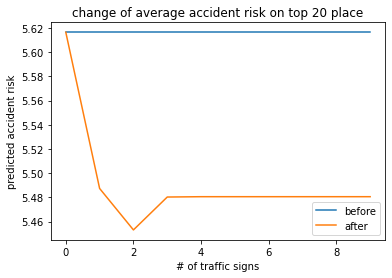

In [61]:
# 도로안내표지판 개수 변화에 따른 어린이보호구역 취약 상위 20 지역의 위험도 평균 변화

clist = ['단속카메라','도로안내표지','횡단보도_전체면적','신호등','단속횟수','단속횟수_횡단보도위','traffic_sum',
         'freq_sum','초등학교_300m','유치원_500m','cctv','버스정류장','체육시설','학원','car_cnt','float_type_H','float_type_M']


# bef는 상위 20 곳의 원래 사고 예측값 평균 모음 리스트
# aft는 상위 20 곳의 시설물 설치 시 예측값 평균 모음 리스트
# count는 변화시킬 시설물의 개수

bef = []
aft = []
count = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    
    # 시설물을 i만큼 늘릴 때 상위 20 곳 각각의 위험도 변화 저장
    bef_i = []
    aft_i = []
    
    # 20 곳 각각의 위험도 변화 산출
    for j in [str(x) for x in weak_ptz_top20.gid]:
        
        # x_bef는 원래 변수값 / x_aft는 시설물 추가 설치 시 변수값
        x_bef = weak_ptz_top20.loc[np.where(weak_ptz_top20.gid==j)[0], clist]
        x_aft = x_bef.copy()

        x_aft.도로안내표지 = x_bef.도로안내표지 + i
        
        bef_i.append(model_ESB.predict(x_bef)[0])
        aft_i.append(model_ESB.predict(x_aft)[0])
    
    # 20 곳의 평균 위험도 저장
    bef.append(np.mean(bef_i))
    aft.append(np.mean(aft_i))    

    
    
# 시설물 설치 개수에 따른 변화량 시각화
series1 = pd.Series(bef, index=list(count))
series2 = pd.Series(aft, index=list(count))
series1.plot()
series2.plot()    
plt.xlabel('# of traffic signs')
plt.ylabel('predicted accident risk')
plt.title('change of average accident risk on top 20 place')
plt.legend(['before', 'after'])

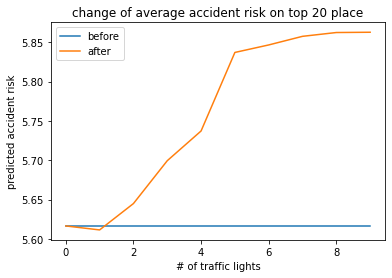

In [62]:
# 신호등 설치 개수 변화에 따른 어린이보호구역 취약 상위 20 지역의 위험도 평균 변화

clist = ['단속카메라','도로안내표지','횡단보도_전체면적','신호등','단속횟수','단속횟수_횡단보도위','traffic_sum',
         'freq_sum','초등학교_300m','유치원_500m','cctv','버스정류장','체육시설','학원','car_cnt','float_type_H','float_type_M']


# bef는 상위 20 곳의 원래 사고 예측값 평균 모음 리스트
# aft는 상위 20 곳의 시설물 설치 시 예측값 평균 모음 리스트
# count는 변화시킬 시설물의 개수

bef = []
aft = []
count = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    
    # 시설물을 i만큼 늘릴 때 상위 20 곳 각각의 위험도 변화 저장
    bef_i = []
    aft_i = []
    
    # 20 곳 각각의 위험도 변화 산출
    for j in [str(x) for x in weak_ptz_top20.gid]:
        
        # x_bef는 원래 변수값 / x_aft는 시설물 추가 설치 시 변수값
        x_bef = weak_ptz_top20.loc[np.where(weak_ptz_top20.gid==j)[0], clist]
        x_aft = x_bef.copy()

        x_aft.신호등 = x_bef.신호등 + i
        
        bef_i.append(model_ESB.predict(x_bef)[0])
        aft_i.append(model_ESB.predict(x_aft)[0])
    
    # 20 곳의 평균 위험도 저장
    bef.append(np.mean(bef_i))
    aft.append(np.mean(aft_i))    

    
# 시설물 설치 개수에 따른 변화량 시각화
series1 = pd.Series(bef, index=list(count))
series2 = pd.Series(aft, index=list(count))
series1.plot()
series2.plot()    
plt.xlabel('# of traffic lights')
plt.ylabel('predicted accident risk')
plt.title('change of average accident risk on top 20 place')
plt.legend(['before', 'after'])

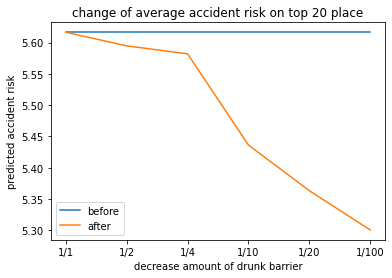

In [63]:
# 주정차 단속횟수 감소에 따른 어린이보호구역 취약 상위 20 지역의 위험도 평균 변화

clist = ['단속카메라','도로안내표지','횡단보도_전체면적','신호등','단속횟수','단속횟수_횡단보도위','traffic_sum',
         'freq_sum','초등학교_300m','유치원_500m','cctv','버스정류장','체육시설','학원','car_cnt','float_type_H','float_type_M']


# bef는 상위 20 곳의 원래 사고 예측값 평균 모음 리스트
# aft는 상위 20 곳의 시설물 설치 시 예측값 평균 모음 리스트
# count는 원래 주정차 단속횟수에 곱해줄 값

bef = []
aft = []
count = ['1/1', '1/2', '1/4', '1/10', '1/20', '1/100']

for i in [1, 0.5, 0.25, 0.1, 0.05, 0.01]:
    
    # 주정차 단속을 i배만큼 감소시킬 때 상위 20 곳 각각의 위험도 변화 저장
    bef_i = []
    aft_i = []
    
    # 20 곳 각각의 위험도 변화 산출
    for j in [str(x) for x in weak_ptz_top20.gid]:
        
        # x_bef는 원래 변수값 / x_aft는 주정차 단속횟수 감소 후 변수값
        x_bef = weak_ptz_top20.loc[np.where(weak_ptz_top20.gid==j)[0], clist]
        x_aft = x_bef.copy()

        x_aft.단속횟수 = x_bef.단속횟수 * i
        
        bef_i.append(model_ESB.predict(x_bef)[0])
        aft_i.append(model_ESB.predict(x_aft)[0])
    
    # 20 곳의 평균 위험도 저장
    bef.append(np.mean(bef_i))
    aft.append(np.mean(aft_i))    

    
# 주정차 단속 감소에 따른 변화량 시각화
series1 = pd.Series(bef, index=list(count))
series2 = pd.Series(aft, index=list(count))
series1.plot()
series2.plot()    
plt.xlabel('decrease amount of drunk barrier')
plt.ylabel('predicted accident risk')
plt.title('change of average accident risk on top 20 place')
plt.legend(['before', 'after'])